In [1]:
#Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:

#  Data Loading & Inspection

train_df0 = pd.read_csv('customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('customer_churn_dataset-testing-master.csv')

# Drop rows where target "Churn" is missing
train_df = train_df0.dropna(subset=['Churn'])

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nColumns:", train_df.columns.tolist())
print("\nData Types:\n", train_df.dtypes)
print("\nMissing Values:\n", train_df.isnull().sum())
print("\nChurn Distribution:\n", train_df['Churn'].value_counts())


Train shape: (440832, 12)
Test shape: (64374, 12)

Columns: ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']

Data Types:
 CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

Missing Values:
 CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Churn Distribution:
 Churn
1.0    249999
0.0    190833
Name: count, dtype: in

## Data preprocessing 

In [3]:

# Drop ID & Separate Categorical/Numerical Columns
# Remove CustomerID
train_df = train_df.drop('CustomerID', axis=1)
test_df = test_df.drop('CustomerID', axis=1)

# Identify categorical & numerical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')

numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in numerical_cols:
    numerical_cols.remove('Churn')

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)



Categorical columns: ['Gender', 'Subscription Type', 'Contract Length']
Numerical columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


In [4]:

#Label Encoding

label_encoders = {}
category_sizes = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le
    category_sizes[col] = len(le.classes_)

print("\nCategory sizes (for embeddings):", category_sizes)



Category sizes (for embeddings): {'Gender': 2, 'Subscription Type': 3, 'Contract Length': 3}


In [5]:
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

In [6]:

# Train/Validation/Test Split


X_train_full = train_df.drop('Churn', axis=1)
y_train_full = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (352665, 10)
Val: (88167, 10)
Test: (64374, 10)


In [7]:

#  Build Embedding Neural Network

def create_embedding_nn(categorical_cols, category_sizes, numerical_cols):

    inputs = []
    embeddings = []

    # Embedding for each categorical column
    for col in categorical_cols:
        safe_name = col.replace(" ", "_")
        inp = layers.Input(shape=(1,), name=f'input_{safe_name}')
        inputs.append(inp)

        embed_dim = min(50, category_sizes[col] // 2 + 1)
        emb = layers.Embedding(category_sizes[col], embed_dim)(inp)
        emb = layers.Flatten()(emb)
        embeddings.append(emb)

    # Numerical Input
    num_inp = layers.Input(shape=(len(numerical_cols),), name='numerical_input')
    inputs.append(num_inp)

    # Merge all embeddings + numeric
    merged = layers.Concatenate()(embeddings + [num_inp])

    # Dense layers
    x = layers.Dense(256, activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs, output)

model = create_embedding_nn(categorical_cols, category_sizes, numerical_cols)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_Gender (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_Subscription_Type       │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_Contract_Length         │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 2)              │               4 │ input_Gender[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 2)              │               6 │ input_Subscription_Type[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1, 2)              │               6 │ input_Contract_Length[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2)                 │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 2)                 │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 2)                 │               0 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numerical_input (InputLayer)  │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 13)                │               0 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0],           │
│                               │                           │                 │ flatten_2[0][0],           │
│                               │                           │                 │ numerical_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │           3,584 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256)               │           1,024 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 48,657 (190.07 KB)

 Trainable params: 47,761 (186.57 KB)

 Non-trainable params: 896 (3.50 KB)

### Splitting Training Data

In [8]:

#  Compile Model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)


### Building Entity Embedding Neural Network

### Embedding layers for categorical variables

In [9]:

# 📌 CELL 9 — Convert Data to Model Input Format

def prepare_input(df, categorical_cols, numerical_cols):
    inputs = []
    for col in categorical_cols:
        inputs.append(df[col].values.reshape(-1, 1))
    inputs.append(df[numerical_cols].values)
    return inputs

X_train_input = prepare_input(X_train, categorical_cols, numerical_cols)
X_val_input = prepare_input(X_val, categorical_cols, numerical_cols)
X_test_input = prepare_input(X_test, categorical_cols, numerical_cols)


In [10]:

# 📌 CELL 10 — Class Weights & Callbacks


class_counts = np.bincount(y_train)
total = len(y_train)

class_weight = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1]),
}

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28824\511650889.py:5: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  class_counts = np.bincount(y_train)


In [11]:

# 📌 CELL 11 — Train Model


history = model.fit(
    X_train_input, y_train,
    validation_data=(X_val_input, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step - accuracy: 0.9706 - auc: 0.9930 - loss: 0.0847 - val_accuracy: 0.9884 - val_auc: 0.9986 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 2/10
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 93s 8ms/step - accuracy: 0.9865 - auc: 0.9968 - loss: 0.0451 - val_accuracy: 0.9918 - val_auc: 0.9993 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 3/10
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.9885 - auc: 0.9976 - loss: 0.0379 - val_accuracy: 0.9906 - val_auc: 0.9990 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 4/10
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.9896 - auc: 0.9979 - loss: 0.0347 - val_accuracy: 0.9915 - val_auc: 0.9990 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 5/10
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.9902 - auc: 0.9981 - loss: 0.0326 - val_accuracy: 0.9917 - val_auc: 0.9993 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 6/10
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 100s 9ms/s

In [12]:
import joblib

# save model
model.save("churn_model.h5")

# save encoders
joblib.dump(label_encoders, "label_encoders.pkl")

# save scaler
joblib.dump(scaler, "scaler.pkl")

# save metadata
metadata = {
    "categorical_cols": categorical_cols,
    "numerical_cols": numerical_cols,
    "category_sizes": category_sizes
}
joblib.dump(metadata, "metadata.pkl")

print("All files saved successfully!")


All files saved successfully!


In [13]:

#  Evaluation (Val + Test)

def evaluate_model(model, X_input, y_true, name="Validation"):
    print(f"\n===== {name} Evaluation =====")
    proba = model.predict(X_input).flatten()
    preds = (proba > 0.5).astype(int)

    print(f"AUC-ROC: {roc_auc_score(y_true, proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, preds))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, preds))

evaluate_model(model, X_val_input, y_val, "Validation")
evaluate_model(model, X_test_input, y_test, "Test")



===== Validation Evaluation =====
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
AUC-ROC: 0.9998

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     38167
         1.0       1.00      0.99      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167


Confusion Matrix:
[[38158     9]
 [  366 49634]]

===== Test Evaluation =====
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
AUC-ROC: 0.5570

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.07      0.12     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.51     64374
   macro avg       0.73      0.53      0.39     64374
weighted avg       0.75      0.51      0.38     64374


Confusion Matrix:
[[ 2220 31661]
 [   58 30435]]


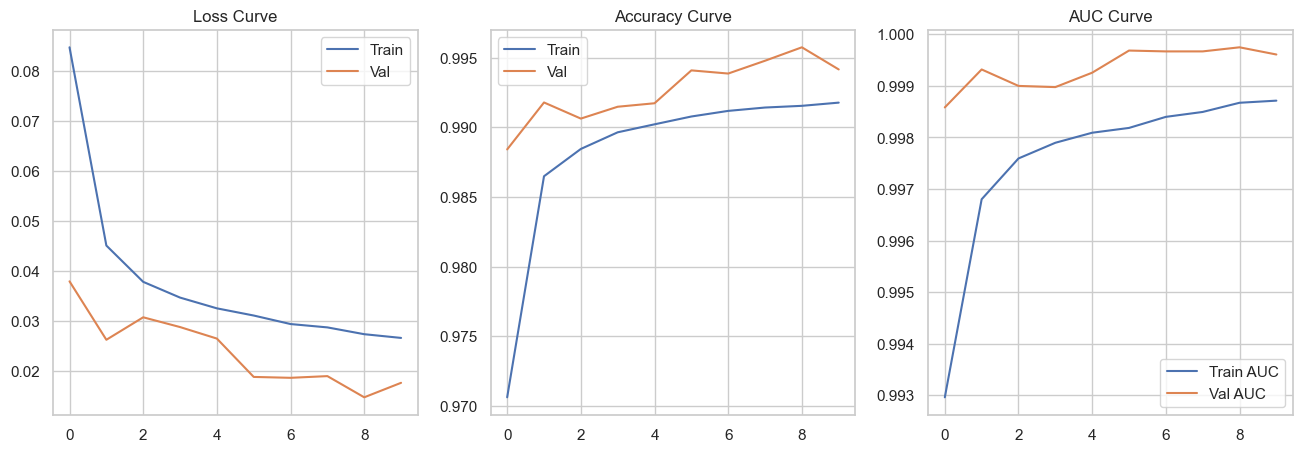

In [14]:

# Training Curves


plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy Curve")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC Curve")
plt.legend()

plt.show()


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
2012/2012 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


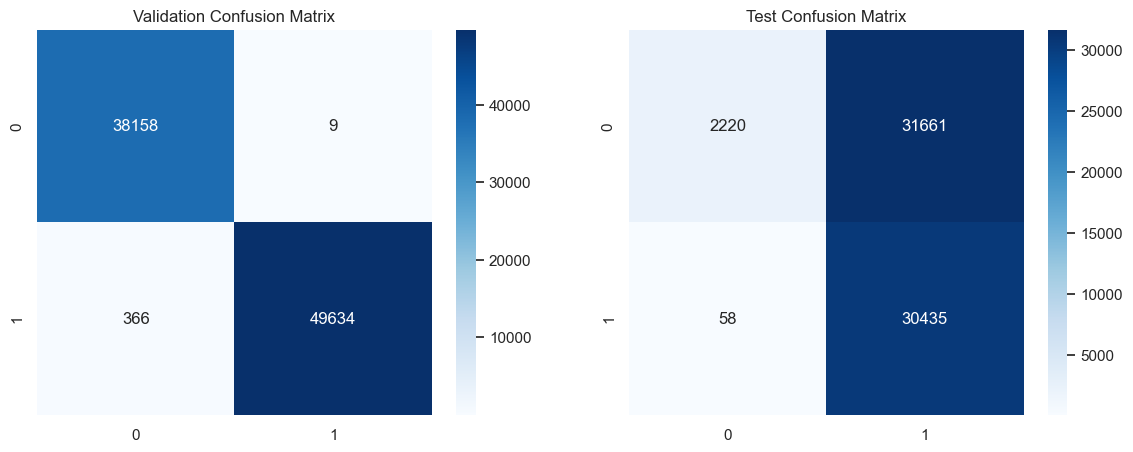

In [15]:

# Confusion Matrices


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_val, (model.predict(X_val_input).flatten()>0.5).astype(int)),
            annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Validation Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, (model.predict(X_test_input).flatten()>0.5).astype(int)),
            annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Test Confusion Matrix")

plt.show()
